# Machine Learning for Assessing Brush Fire Risk in The United States

## Import required packages

In [1]:
# !pip install geopandas shapely
#%pip install xarray
#%pip install zarr
#%pip install fsspec
#%pip install cartopy
#%pip install netCDF4
#%pip install scipy
#%pip install bottleneck
#%pip install gcsfs

In [2]:
#Importing required packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import re
import csv
import xarray as xr
import zarr
import fsspec
import cartopy.crs as ccrs
import glob as glob
import netCDF4 as nc
from netCDF4 import Dataset
from scipy.stats import skew,stats
import bottleneck
import gcsfs
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings("ignore") 

# import geopandas as gpd
# from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

## CMIP6 Data

#### burntFractionAll

In [3]:
#Loading CMIP6 data stored on google cloud
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [4]:
df_burntFractionAll = df.query("variable_id == 'burntFractionAll' & source_id == 'CNRM-ESM2-1' & member_id == 'r1i1p1f2'")

df_burntFractionAll

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
44114,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Lmon,burntFractionAll,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206
53402,CMIP,CNRM-CERFACS,CNRM-ESM2-1,esm-hist,r1i1p1f2,Lmon,burntFractionAll,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20190215
68560,ScenarioMIP,CNRM-CERFACS,CNRM-ESM2-1,ssp245,r1i1p1f2,Lmon,burntFractionAll,gr,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,NaN,20190328
376059,ScenarioMIP,CNRM-CERFACS,CNRM-ESM2-1,ssp585,r1i1p1f2,Lmon,burntFractionAll,gr,gs://cmip6/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM...,NaN,20191021


In [5]:
burntFractionAll_store_present = df_burntFractionAll.zstore.values[0]
print(burntFractionAll_store_present)
mapper = fsspec.get_mapper(burntFractionAll_store_present)
burntFractionAll_present = xr.open_zarr(mapper, consolidated=True)

burntFractionAll_present

gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Lmon/burntFractionAll/gr/v20181206/


<xarray.Dataset>
Dimensions:           (time: 1980, lat: 128, lon: 256, axis_nbounds: 2)
Coordinates:
  * lat               (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon               (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
  * time              (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-1...
    time_bounds       (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
    type              |S255 ...
Dimensions without coordinates: axis_nbounds
Data variables:
    burntFractionAll  (time, lat, lon) float32 dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
Attributes: (12/55)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:            CMIP
    arpege_minor_version:   6.3.2
    branch_method:          standard
    ...                     ...
    variable_id:            burntFractionAll
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/9ffa7596-6d4c-4d9c-8f13-e8db4f33cc7e
    version_id:             v20181206

In [6]:
min_value = burntFractionAll_present['burntFractionAll'].min()
min_value_non_zero = burntFractionAll_present['burntFractionAll'].where(burntFractionAll_present['burntFractionAll'] > 0).min()
max_value = burntFractionAll_present['burntFractionAll'].max()

print(f"Minimum burntFractionAll: {min_value.values}")
print(f"Minimum burntFractionAll (excluding zeros): {min_value_non_zero.values}")
print(f"Maximum burntFractionAll: {max_value.values}")

Minimum burntFractionAll: 0.0
Minimum burntFractionAll (excluding zeros): 8.838542318010973e-15
Maximum burntFractionAll: 1.2239598035812378


In [7]:
# Define a threshold for burnt fraction to classify as fire
fire_threshold = 0.01

# Label the data
burntFractionAll_present['fire_label'] = (burntFractionAll_present['burntFractionAll'] > fire_threshold).astype(int)

In [8]:
burntFractionAll_present

<xarray.Dataset>
Dimensions:           (time: 1980, lat: 128, lon: 256, axis_nbounds: 2)
Coordinates:
  * lat               (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon               (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
  * time              (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-1...
    time_bounds       (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
    type              |S255 ...
Dimensions without coordinates: axis_nbounds
Data variables:
    burntFractionAll  (time, lat, lon) float32 dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
    fire_label        (time, lat, lon) int32 dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
Attributes: (12/55)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:            CMIP
    arpege_minor_version:   6.3.2
    branch_method:          standard
    ...                     ...
    variable_id:            burntFractionAll
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/9ffa7596-6d4c-4d9c-8f13-e8db4f33cc7e
    version_id:             v20181206

In [9]:
# Convert the DataArray to a pandas DataFrame
label_df = burntFractionAll_present['fire_label'].to_dataframe()

# Use value_counts on the DataFrame
label_counts = label_df['fire_label'].value_counts()

# Display the value counts
print(label_counts)

0    62745439
1     2135201
Name: fire_label, dtype: int64


In [10]:
burntFractionAll_combined = burntFractionAll_present.fire_label
burntFractionAll_df = burntFractionAll_combined.to_dataframe()
burntFractionAll_df

type  fire_label
time                lat        lon                                
1850-01-16 12:00:00 -88.927735 0.00000    b'typeburnt'           0
                               1.40625    b'typeburnt'           0
                               2.81250    b'typeburnt'           0
                               4.21875    b'typeburnt'           0
                               5.62500    b'typeburnt'           0
...                                                ...         ...
2014-12-16 12:00:00  88.927735 352.96875  b'typeburnt'           0
                               354.37500  b'typeburnt'           0
                               355.78125  b'typeburnt'           0
                               357.18750  b'typeburnt'           0
                               358.59375  b'typeburnt'           0

[64880640 rows x 2 columns]

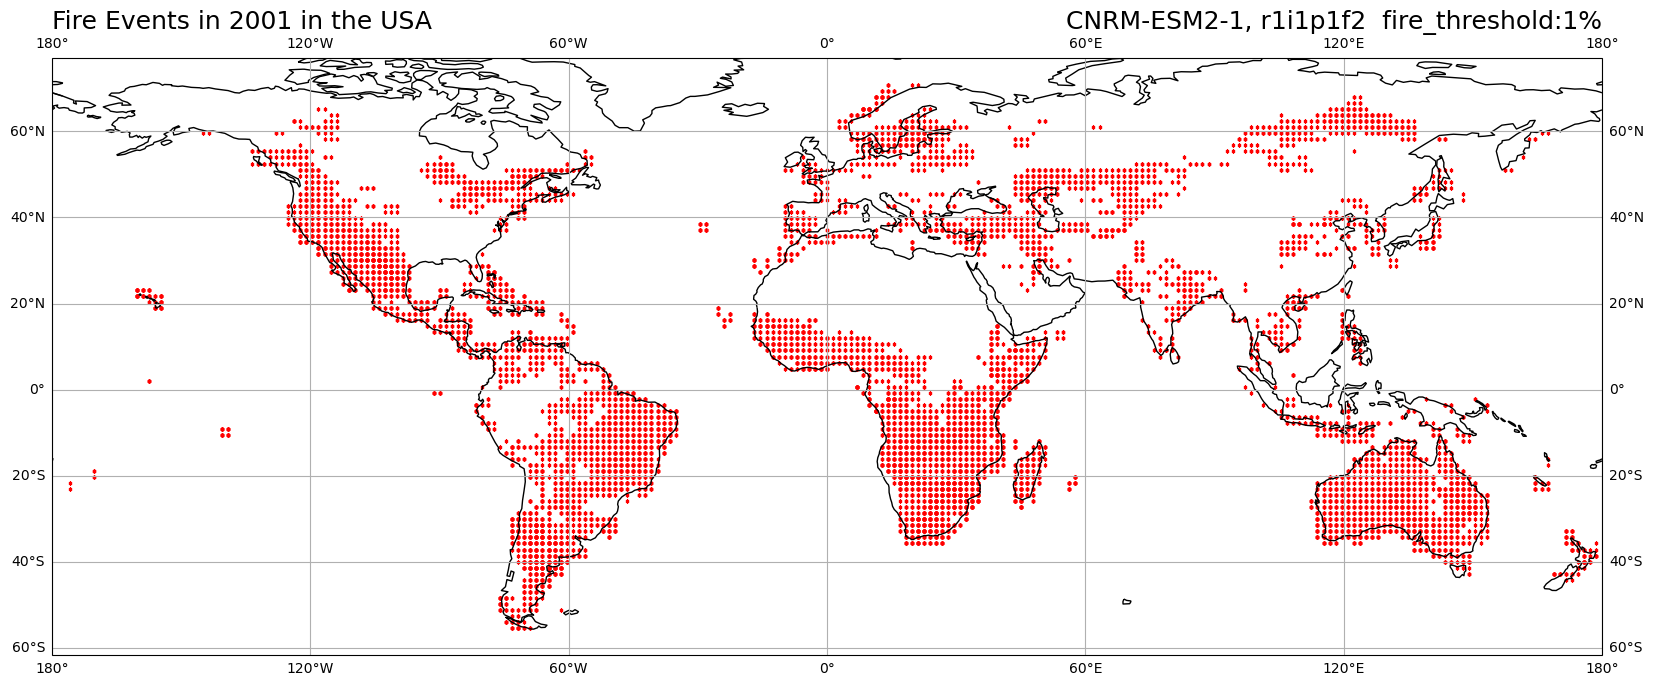

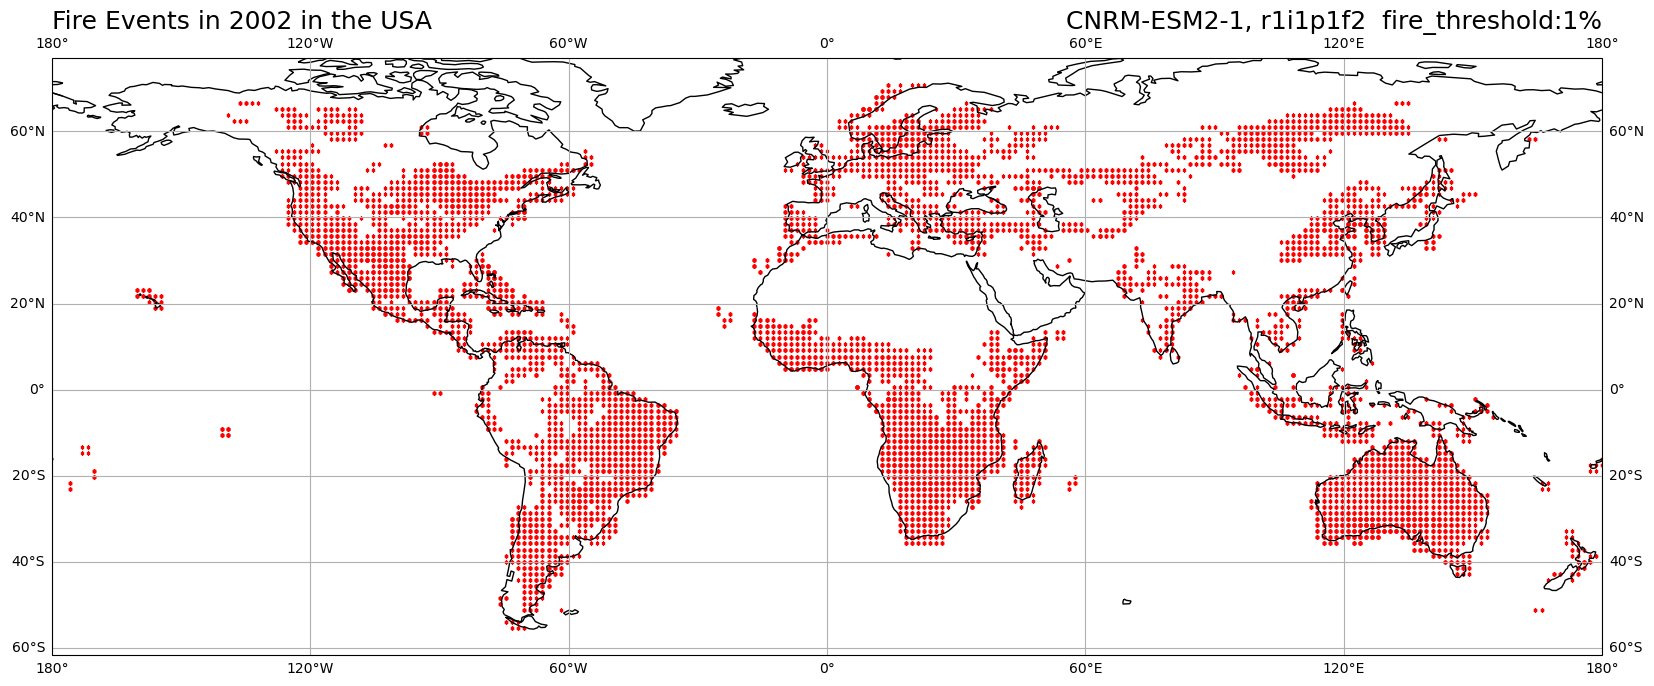

In [ ]:
for year in range(2001, 2014):
    # Load your data for the specific year
    burntFractionAll_present_year = burntFractionAll_present.sel(time=slice(f'{year}-01-01',f'{year}-12-31'))

    burntFractionAll_combined_year = burntFractionAll_present_year.fire_label
    burntFractionAll_df_year = burntFractionAll_combined_year.to_dataframe()
    
    burntFractionAll_df_year.to_csv(f'./plot/data/burntFractionAll_Global_{year}.csv')
    
    burntFractionAll_df_year = pd.read_csv(f'./plot/data/burntFractionAll_Global_{year}.csv')

    # Filter the data for fire events
    fire_events = burntFractionAll_df_year[burntFractionAll_df_year['fire_label'] == 1]

    # Extract latitude and longitude
    fire_lat = fire_events['lat']
    fire_lon = fire_events['lon']

    # Create the plot
    plt.figure(figsize=(20, 14))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.scatter(fire_lon, fire_lat, color='red', marker=',', s=1, transform=ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    plt.title(f"Fire Events in {year} in the USA", loc='left', fontsize=18)
    plt.title('CNRM-ESM2-1, r1i1p1f2  fire_threshold:1%', loc='right', fontsize=18)
    
    plt.savefig(f'./plot/geomap/burntFractionAll_Global_{year}.png')
    plt.show()


#### pr

In [27]:
df_pr = df.query("variable_id == 'pr' & source_id == 'CNRM-ESM2-1' & member_id == 'r1i1p1f2' & experiment_id == 'historical' & table_id == 'Amon'")

pr_store_present = df_pr.zstore.values[0]

mapper = fsspec.get_mapper(pr_store_present)
pr_present = xr.open_zarr(mapper, consolidated=True)

pr_combined = pr_present.pr
pr_df = pr_combined.to_dataframe()
pr_df

pr
time                lat        lon                
1850-01-16 12:00:00 -88.927735 0.00000    0.000001
                               1.40625    0.000001
                               2.81250    0.000001
                               4.21875    0.000001
                               5.62500    0.000001
...                                            ...
2014-12-16 12:00:00  88.927735 352.96875  0.000002
                               354.37500  0.000002
                               355.78125  0.000002
                               357.18750  0.000002
                               358.59375  0.000002

[64880640 rows x 1 columns]

#### sfcWind

In [28]:
df_sfcWind = df.query("variable_id == 'sfcWind' & source_id == 'CNRM-ESM2-1' & member_id == 'r1i1p1f2' & experiment_id == 'historical' & table_id == 'Amon'")

df_sfcWind

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
44186,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Amon,sfcWind,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206


In [29]:
sfcWind_store_present = df_sfcWind.zstore.values[0]
mapper = fsspec.get_mapper(sfcWind_store_present)
sfcWind_present = xr.open_zarr(mapper, consolidated=True)

sfcWind_combined = sfcWind_present.sfcWind
sfcWind_df = sfcWind_combined.to_dataframe()
sfcWind_df

height   sfcWind
time                lat        lon                        
1850-01-16 12:00:00 -88.927735 0.00000      10.0  3.439427
                               1.40625      10.0  3.439427
                               2.81250      10.0  3.439427
                               4.21875      10.0  3.439427
                               5.62500      10.0  3.439427
...                                          ...       ...
2014-12-16 12:00:00  88.927735 352.96875    10.0  6.243606
                               354.37500    10.0  6.243606
                               355.78125    10.0  6.243606
                               357.18750    10.0  6.243606
                               358.59375    10.0  6.243606

[64880640 rows x 2 columns]

#### hur

In [35]:
df_hurs = df.query("variable_id == 'hurs' & source_id == 'CNRM-ESM2-1' & member_id == 'r1i1p1f2' & experiment_id == 'historical' & table_id == 'Amon'")

df_hurs

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
44259,CMIP,CNRM-CERFACS,CNRM-ESM2-1,historical,r1i1p1f2,Amon,hurs,gr,gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...,NaN,20181206


In [39]:
hurs_store_present = df_hurs.zstore.values[0]
print(hurs_store_present)
mapper_hurs = fsspec.get_mapper(hurs_store_present)
hurs_present = xr.open_zarr(mapper_hurs, consolidated=True)

hurs_present

gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Amon/hurs/gr/v20181206/


<xarray.Dataset>
Dimensions:      (time: 1980, lat: 128, lon: 256, axis_nbounds: 2)
Coordinates:
    height       float64 ...
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:...
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables:
    hurs         (time, lat, lon) float32 dask.array<chunksize=(600, 128, 256), meta=np.ndarray>
Attributes: (12/55)
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    Conventions:            CF-1.7 CMIP-6.2
    EXPID:                  CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:            CMIP
    arpege_minor_version:   6.3.2
    branch_method:          standard
    ...                     ...
    variable_id:            hurs
    variant_label:          r1i1p1f2
    xios_commit:            1442-shuffle
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/23028409-ef3a-4247-8a81-8f04f2e8c75f
    version_id:             v20181206

In [40]:
hurs_combined = hurs_present.hurs

hurs_df = hurs_combined.to_dataframe()
hurs_df

height       hurs
time                lat        lon                         
1850-01-16 12:00:00 -88.927735 0.00000       2.0  90.531197
                               1.40625       2.0  90.531197
                               2.81250       2.0  90.531197
                               4.21875       2.0  90.531197
                               5.62500       2.0  90.531197
...                                          ...        ...
2014-12-16 12:00:00  88.927735 352.96875     2.0  89.186096
                               354.37500     2.0  89.186096
                               355.78125     2.0  89.186096
                               357.18750     2.0  89.186096
                               358.59375     2.0  89.186096

[64880640 rows x 2 columns]

#### ta

In [37]:
df_tas = df.query("variable_id == 'tas' & source_id == 'CNRM-ESM2-1' & member_id == 'r1i1p1f2' & experiment_id == 'historical' & table_id == 'Amon'")

tas_store_present = df_tas.zstore.values[0]
print(tas_store_present)
mapper = fsspec.get_mapper(tas_store_present)
tas_present = xr.open_zarr(mapper, consolidated=True)

tas_combined = tas_present.tas

tas_df = tas_combined.to_dataframe()
tas_df


gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Amon/tas/gr/v20181206/


height         tas
time                lat        lon                          
1850-01-16 12:00:00 -88.927735 0.00000       2.0  242.565491
                               1.40625       2.0  242.565491
                               2.81250       2.0  242.565491
                               4.21875       2.0  242.565491
                               5.62500       2.0  242.565491
...                                          ...         ...
2014-12-16 12:00:00  88.927735 352.96875     2.0  248.361481
                               354.37500     2.0  248.361481
                               355.78125     2.0  248.361481
                               357.18750     2.0  248.361481
                               358.59375     2.0  248.361481

[64880640 rows x 2 columns]

#### Combining Datasets

In [42]:
frames = [tas_df, sfcWind_df, hurs_df, pr_df, burntFractionAll_df]

combined_df = pd.concat(frames, axis=1)
combined_df = combined_df.dropna(how='any') 
combined_df

height         tas  height  \
time                lat        lon                                     
1850-01-16 12:00:00 -88.927735 0.00000       2.0  242.565491    10.0   
                               1.40625       2.0  242.565491    10.0   
                               2.81250       2.0  242.565491    10.0   
                               4.21875       2.0  242.565491    10.0   
                               5.62500       2.0  242.565491    10.0   
...                                          ...         ...     ...   
2014-12-16 12:00:00  88.927735 352.96875     2.0  248.361481    10.0   
                               354.37500     2.0  248.361481    10.0   
                               355.78125     2.0  248.361481    10.0   
                               357.18750     2.0  248.361481    10.0   
                               358.59375     2.0  248.361481    10.0   

                                           sfcWind  height       hurs  \
time                lat        lon                                      
1850-01-16 12:00:00 -88.927735 0.00000    3.439427     2.0  90.531197   
                               1.40625    3.439427     2.0  90.531197   
                               2.81250    3.439427     2.0  90.531197   
                               4.21875    3.439427     2.0  90.531197   
                               5.62500    3.439427     2.0  90.531197   
...                                            ...     ...        ...   
2014-12-16 12:00:00  88.927735 352.96875  6.243606     2.0  89.186096   
                               354.37500  6.243606     2.0  89.186096   
                               355.78125  6.243606     2.0  89.186096   
                               357.18750  6.243606     2.0  89.186096   
                               358.59375  6.243606     2.0  89.186096   

                                                pr          type  fire_label  
time                lat        lon                                            
1850-01-16 12:00:00 -88.927735 0.00000    0.000001  b'typeburnt'           0  
                               1.40625    0.000001  b'typeburnt'           0  
                               2.81250    0.000001  b'typeburnt'           0  
                               4.21875    0.000001  b'typeburnt'           0  
                               5.62500    0.000001  b'typeburnt'           0  
...                                            ...           ...         ...  
2014-12-16 12:00:00  88.927735 352.96875  0.000002  b'typeburnt'           0  
                               354.37500  0.000002  b'typeburnt'           0  
                               355.78125  0.000002  b'typeburnt'           0  
                               357.18750  0.000002  b'typeburnt'           0  
                               358.59375  0.000002  b'typeburnt'           0  

[64880640 rows x 9 columns]

In [43]:
X = combined_df.iloc[:, :-1] 
y = combined_df.iloc[:, -1] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

'''
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, predictions)

print("precision", precision_score(y_test, predictions))
print("accuracy", accuracy_score(y_test, predictions))
print("recall", recall_score(y_test, predictions))

# Extract values from the confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()
print("tn:", tn)
print("tp:", tp)
print("fn:", fn)
print("fp:", fp)
'''

'\nclf = tree.DecisionTreeClassifier()\nclf = clf.fit(X_train, y_train)\npredictions = clf.predict(X_test)\nconf_matrix = confusion_matrix(y_test, predictions)\n\nprint("precision", precision_score(y_test, predictions))\nprint("accuracy", accuracy_score(y_test, predictions))\nprint("recall", recall_score(y_test, predictions))\n\n# Extract values from the confusion matrix\ntn, fp, fn, tp = conf_matrix.ravel()\nprint("tn:", tn)\nprint("tp:", tp)\nprint("fn:", fn)\nprint("fp:", fp)\n'

In [44]:
from sklearn.metrics import mean_squared_error
clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(mse)
print(np.unique(predictions))

ValueError: could not convert string to float: b'typeburnt'